# CSV loading with Multi-Threading
## Comparing Julia's CSV.jl with Python's pandas and R's data.table

In [1]:
Threads.nthreads()

10

In [2]:
using CSV, CSV.DataFrames #for loading csv files
using BenchmarkTools #for benchmarking load time
using StatsPlots, CategoricalArrays #for plotting

In [3]:
function plot_times(t_array)
    group_name = CategoricalArray(repeat(["Julia","R", "Python"], inner = 2), ordered=true)
    names_ = repeat(["1 thread", "20 threads"], outer=3)
    groupedbar(names_, t_array,  group = group_name, ylabel = "milliseconds", 
        title = "CSV loading with multi-threading", color = [:purple2 :grey70  :deepskyblue2],legend =:best)
end

plot_times (generic function with 1 method)

## Homogenous Dataset
This dataset contains 50M rows and 5 columns. The dataset is a simulation of apple stock prices over two decades. The columns are open, high, low and close; all columns are Floats

### Single threaded

In [4]:
run(`R -e "library(microbenchmark);library(data.table);setDTthreads(1);benchmark = microbenchmark(df50 = fread('./csv-benchmarks-master/uniform_float64.csv'),times=4);print(benchmark)"`)


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(microbenchmark);library(data.table);setDTthreads(1);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/uniform_float64.csv'),times=4);print(benchmark)
Unit: milliseconds
 expr      min       lq     mean   median       uq      max neval
 df50 106.8524 107.1032 136.9665 117.4171 166.8298 206.1794     4
> 
> 


Process(`R -e "library(microbenchmark);library(data.table);setDTthreads(1);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/uniform_float64.csv'),times=4);print(benchmark)"`, ProcessExited(0))

In [5]:
run(`python3 -m timeit -s "import pandas" -p "pandas.read_csv('./csv-benchmarks-master/uniform_float64.csv')"`)

1 loop, best of 5: 226 msec per loop


Process(`python3 -m timeit -s 'import pandas' -p "pandas.read_csv('/data/dpk1729/csv-benchmarks-master/uniform_float64.csv')"`, ProcessExited(0))

In [6]:
@btime CSV.read("./csv-benchmarks-master/uniform_float64.csv", threaded=false)

  147.875 ms (2242 allocations: 32.86 MiB)


,col1,col2,col3,col4,col5,col6,col7,col8
,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,0.311115,0.918089,missing,0.227775,0.794346,0.382668,0.399535,0.989645
2,0.799122,missing,0.780652,0.736077,missing,0.704279,missing,missing
3,0.508057,missing,0.667188,missing,missing,missing,0.00099084,missing
4,missing,0.362406,missing,missing,0.370311,0.886238,missing,0.853112
5,0.969545,missing,0.79815,0.120027,missing,0.389666,missing,missing
6,0.200118,missing,0.436662,missing,0.688606,missing,missing,0.510718
7,0.645989,0.840897,missing,missing,0.753339,0.339951,missing,0.30921
8,missing,0.963547,missing,missing,0.189656,missing,missing,missing
9,0.338033,0.376711,0.490633,missing,missing,0.195923,0.629909,0.871364


### Multi threaded

In [7]:
run(`R -e "library(microbenchmark);library(data.table);setDTthreads(10);benchmark = microbenchmark(df50 = fread('./csv-benchmarks-master/uniform_float64.csv'),times=4);print(benchmark)"`)


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(microbenchmark);library(data.table);setDTthreads(10);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/uniform_float64.csv'),times=4);print(benchmark)
Unit: milliseconds
 expr      min       lq     mean   median       uq      max neval
 df50 49.95472 51.55505 71.46087 63.44895 91.36668 108.9908     4
> 
> 


Process(`R -e "library(microbenchmark);library(data.table);setDTthreads(10);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/uniform_float64.csv'),times=4);print(benchmark)"`, ProcessExited(0))

In [8]:
@btime CSV.read("./csv-benchmarks-master/uniform_float64.csv", threaded=true)

  34.830 ms (12417 allocations: 33.70 MiB)


,col1,col2,col3,col4,col5,col6,col7,col8
,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,0.311115,0.918089,missing,0.227775,0.794346,0.382668,0.399535,0.989645
2,0.799122,missing,0.780652,0.736077,missing,0.704279,missing,missing
3,0.508057,missing,0.667188,missing,missing,missing,0.00099084,missing
4,missing,0.362406,missing,missing,0.370311,0.886238,missing,0.853112
5,0.969545,missing,0.79815,0.120027,missing,0.389666,missing,missing
6,0.200118,missing,0.436662,missing,0.688606,missing,missing,0.510718
7,0.645989,0.840897,missing,missing,0.753339,0.339951,missing,0.30921
8,missing,0.963547,missing,missing,0.189656,missing,missing,missing
9,0.338033,0.376711,0.490633,missing,missing,0.195923,0.629909,0.871364


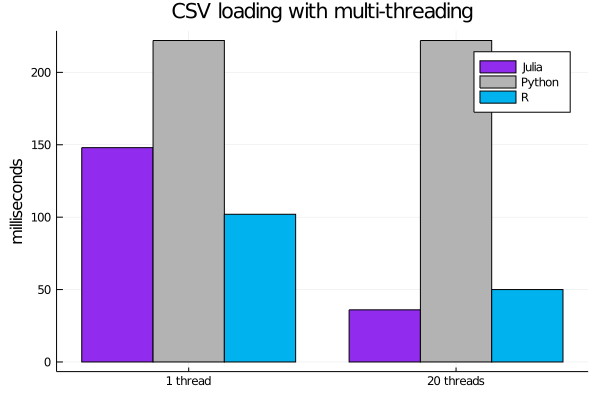

In [9]:
plot_times([148,36,102,50,222,222])

## Heterogenous Dataset

### Single threaded

In [10]:
run(`R -e "library(microbenchmark);library(data.table);setDTthreads(1);benchmark = microbenchmark(df50 = fread('./csv-benchmarks-master/mixed.csv'),times=4);print(benchmark)"`)


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(microbenchmark);library(data.table);setDTthreads(1);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/mixed.csv'),times=4);print(benchmark)
Unit: milliseconds
 expr      min       lq     mean  median       uq     max neval
 df50 302.6076 357.2326 446.0051 469.735 534.7776 541.943     4
> 
> 


Process(`R -e "library(microbenchmark);library(data.table);setDTthreads(1);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/mixed.csv'),times=4);print(benchmark)"`, ProcessExited(0))

In [11]:
run(`python3 -m timeit -s "import pandas" -p "pandas.read_csv('./csv-benchmarks-master/mixed.csv')"`)

1 loop, best of 5: 397 msec per loop


Process(`python3 -m timeit -s 'import pandas' -p "pandas.read_csv('/data/dpk1729/csv-benchmarks-master/mixed.csv')"`, ProcessExited(0))

In [12]:
@btime CSV.read("./csv-benchmarks-master/mixed.csv", threaded=false)

  138.789 ms (158672 allocations: 47.27 MiB)


,col1,col2,col3,col4,col5
,Float64?,Float64?,Int64?,Dates.D…?,String?
1,0.164184,missing,-8618047875453619626,missing,J7BSebe75ZSElvwjLCmP
2,missing,missing,-50295243866911532,missing,missing
3,0.742546,0.4025,missing,missing,missing
4,missing,0.3716,4175438224706417676,missing,missing
5,missing,0.1643,-7177638387897108480,1960-10-17T14:20:12,missing
6,missing,0.4566,9111019825973752052,1955-09-04T18:25:02,qj0noCjbt5VBnBbAn6dZ
7,missing,missing,-8407312498829477465,1995-01-10T02:45:19,missing
8,0.532037,0.3458,missing,missing,missing
9,0.629863,0.2822,missing,1956-05-15T14:56:43,v807lN9xkiS6Q8aqx0Pz


### Multi threaded

In [13]:
run(`R -e "library(microbenchmark);library(data.table);setDTthreads(10);benchmark = microbenchmark(df50 = fread('./csv-benchmarks-master/mixed.csv'),times=4);print(benchmark)"`)


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(microbenchmark);library(data.table);setDTthreads(10);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/mixed.csv'),times=4);print(benchmark)
Unit: milliseconds
 expr      min       lq     mean   median       uq      max neval
 df50 296.6476 367.3282 469.6355 494.0468 571.9427 593.8006     4
> 
> 


Process(`R -e "library(microbenchmark);library(data.table);setDTthreads(10);benchmark = microbenchmark(df50 = fread('/data/dpk1729/csv-benchmarks-master/mixed.csv'),times=4);print(benchmark)"`, ProcessExited(0))

In [14]:
@btime CSV.read("./csv-benchmarks-master/mixed.csv", threaded=true)

  27.635 ms (113546 allocations: 43.77 MiB)


,col1,col2,col3,col4,col5
,Float64?,Float64?,Int64?,Dates.D…?,String?
1,0.164184,missing,-8618047875453619626,missing,J7BSebe75ZSElvwjLCmP
2,missing,missing,-50295243866911532,missing,missing
3,0.742546,0.4025,missing,missing,missing
4,missing,0.3716,4175438224706417676,missing,missing
5,missing,0.1643,-7177638387897108480,1960-10-17T14:20:12,missing
6,missing,0.4566,9111019825973752052,1955-09-04T18:25:02,qj0noCjbt5VBnBbAn6dZ
7,missing,missing,-8407312498829477465,1995-01-10T02:45:19,missing
8,0.532037,0.3458,missing,missing,missing
9,0.629863,0.2822,missing,1956-05-15T14:56:43,v807lN9xkiS6Q8aqx0Pz


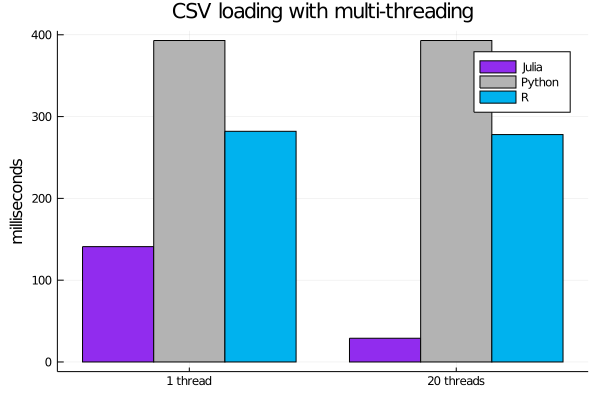

In [15]:
plot_times([141,29,282,278,393,393])